# Image Classification with Transformers

## Introduction

In this notebook, we will use the `transformers` library to fine-tune a pre-trained transformer model for image classification. We will use the `ViT` model, which is a transformer model that was designed for image classification tasks. We will fine-tune the model on the `CIFAR-10` dataset, which is a dataset of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The dataset is divided into 50,000 training images and 10,000 testing images.

`ViT` is a transformer model that was designed for image classification tasks. It works by dividing an image into patches, and then processing each patch with a transformer encoder. The model then uses a classification head to predict the class of the image. The model is pre-trained on the `ImageNet` dataset, which is a large dataset of natural images.

The architecture of the `ViT` model is as follows:

1. Input Embeddings: The input to the model is an image, which is divided into patches. Each patch is then linearly embedded to the same dimension as the model's hidden dimension. The formula for the number of patches are as follows:
2. Positional Embeddings: The model uses learnable positional embeddings to encode the position of each patch in the image.
3. Transformer Encoder: The model uses a transformer encoder to process the patches. The encoder consists of multiple layers which are:
    - Multi-Head Self-Attention: The model uses multi-head self-attention to capture the relationships between different patches in the image.
    - Feed-Forward Neural Network: The model uses a feed-forward neural network to process the output of the self-attention layer.
    - Residual Connection: The model uses residual connections around each sub-layer, followed by layer normalization.
4. Classification Head: The model uses a classification head to predict the class of the image.

The formula for different blocks are as follows:

1. Embedding Block: The embedding block consists of a linear layer to embed the patches, followed by a positional embedding layer.
    - `x = patch_embeddings(x) + position_embeddings`
    - `patch_embeddings`: Linear layer to embed the patches
      - $PE_{(patch, i)} = xW_{patch} + b_{patch}$
    - `position_embeddings`: Positional embeddings to encode the position of each patch
      - $PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})$

2. Transformer Encoder Block: The transformer encoder block consists of a multi-head self-attention layer, followed by a feed-forward neural network.
    - `self_attention`: Multi-head self-attention layer
      - $softmax(\frac{QK^T}{\sqrt{d_k}})V = Attention(Q, K, V)$
      - $concat(head_1, head_2, ..., head_n)W^O = MultiHead(Q, K, V)$
    - `feed_forward`: Feed-forward neural network
      - $FFN(x) = max(0, xW_1 + b_1)W_2 + b_2$
      - `W_1`, `b_1`: Weight and bias of the first linear layer
    - `LayerNorm(x)`: Layer normalization
      - $LayerNorm(x) = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}}$
    - `Residual(x, y)`: Residual connection
      - $Residual(x, y) = x + y$

[This paper](https://openaccess.thecvf.com/content/ICCV2023/papers/Xu_FDViT_Improve_the_Hierarchical_Architecture_of_Vision_Transformer_ICCV_2023_paper.pdf) proposes a novel hierarchical architecture for vision transformers called FDViT to address the challenge of high computational costs in vision transformers. The key ideas are:
1. Introducing a flexible downsampling (FD) layer that is not limited to integer stride, allowing for smooth reduction of spatial dimensions to avoid excessive information loss.
2. Using a masked auto-encoder architecture to facilitate the training of the FD layers and generate informative outputs.
The proposed FDViT achieves better classification performance with fewer FLOPs and parameters compared to existing hierarchical vision transformer models. Experiments on ImageNet, COCO, and ADE20K datasets demonstrate the effectiveness of the method.

Also [this paper](https://research.google/blog/improving-vision-transformer-efficiency-and-accuracy-by-learning-to-tokenize/) discusses a module called TokenLearner that can be used to improve the efficiency and accuracy of Vision Transformer (ViT) models. TokenLearner is a learnable module that generates a smaller set of adaptive tokens from the input image or video, rather than using a fixed, uniform tokenization. This reduces the number of tokens that need to be processed by the subsequent Transformer layers, leading to significant savings in memory and computation without compromising performance. The document presents experiments showing that inserting TokenLearner at different locations within a ViT model can achieve comparable or better accuracy than the baseline ViT, while reducing the computational cost by up to two-thirds. TokenLearner is particularly effective for video understanding tasks, where it achieves state-of-the-art performance on several benchmarks.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay

import torchvision
from torchvision import datasets, models
from torchvision.models import vision_transformer
from torchvision import transforms as torchvision_transforms

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchinfo import summary

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation
from keras.models import Sequential, Model, load_model, save_model, model_from_json
from keras.applications import VGG19, ResNet152V2, DenseNet201, EfficientNetV2L
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import OneHotEncoder
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, Callback
from keras import backend as K
from keras.metrics import categorical_crossentropy
from keras.datasets import cifar10
from keras.utils import to_categorical

from transformers import DeiTModel, DeiTConfig, DeiTForImageClassification, DeiTFeatureExtractor, AutoFeatureExtractor, AutoModel, AutoConfig, AutoTokenizer, AutoModelForImageClassification, ViTFeatureExtractor, ViTModel, ViTForImageClassification
from pytorch_pretrained_vit import ViT, load_pretrained_weights
import timm

import cv2
import PIL as Image
from skimage import transform

import random
import tqdm
import os
import time
from tabulate import tabulate

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
torch.cuda.empty_cache()

## Fine-Tuning CNN

we want to use transfer learning on both CNN and Transformers. we call our fine-tuning restrictive because we only unfreeze the last block of the models to identify which model architecture has the best raw transfer learning capabilities.

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)
y_val_onehot = to_categorical(y_val)

In [5]:
# if you want to resize the images

# for x in x_train: 
#     x = transform.resize(x, (224, 224, 3), mode="constant")
# for x in x_val:
#     x = transform.resize(x, (224, 224, 3), mode="constant")
# for x in x_test:
#     x = transform.resize(x, (224, 224, 3), mode="constant")   

In [6]:
cifar10_labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
cifar10_input_shape = (32, 32, 3)

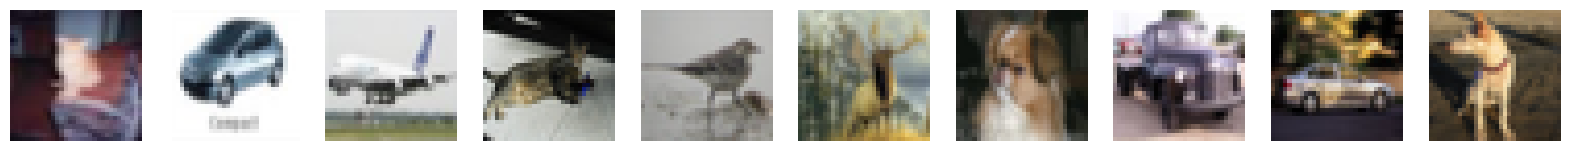

In [7]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    axes[i].imshow(x_train[i])
    axes[i].axis("off")
plt.show()

In [8]:
x_train = x_train / 255
x_val = x_val / 255
x_test = x_test / 255

In [9]:
def plot_metrics(history: keras.callbacks.History):

    fig, axs = plt.subplots(2, 1, figsize=(8, 8))

    axs[0].plot(history.history["loss"], label="Training Loss")
    axs[0].plot(history.history["val_loss"], label="Validation Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(history.history["accuracy"], label="Training Accuracy")
    axs[1].plot(history.history["val_accuracy"], label="Validation Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [10]:
def plot_metrics_pytorch(train_loss: list, val_loss: list, train_acc: list, val_acc: list):

    fig, axs = plt.subplots(2, 1, figsize=(8, 8))

    axs[0].plot(train_loss, label="Training Loss")
    axs[0].plot(val_loss, label="Validation Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(train_acc, label="Training Accuracy")
    axs[1].plot(val_acc, label="Validation Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [11]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=45)
    plt.show()

In [12]:
def layer_specific_summary(model: keras.Model):
    for i, layer in enumerate(model.layers):
        print(i, layer.name, layer.trainable)

In [13]:
def save_model(model: keras.Model, model_name: str):
    model_json = model.to_json()
    with open(f"../models/{model_name}.json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(f"{model_name}.h5")
    print("Saved model to disk")

In [14]:
def save_model_pytorch(model: nn.Module, model_name: str):
    torch.save(model.state_dict(), f"../models/{model_name}.pth")
    print("Saved model to disk")

In [15]:
def load_model(model_name: str) -> keras.Model:
    json_file = open(f"../models/{model_name}.json", "r")
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(f"{model_name}.h5")
    print("Loaded model from disk")
    return loaded_model

In [16]:
def load_model_pytorch(model: nn.Module, model_name: str) -> nn.Module:
    model.load_state_dict(torch.load(f"../models/{model_name}.pth"))
    print("Loaded model from disk")
    return model

In [17]:
def scheduler(epoch: int, lr: float) -> float:
    # The learning rate reduces by a factor of 0.9 and has a minimum value of 0.0000001.
    return max(0.0000001, lr * 0.9)

LR_sched = LearningRateScheduler(scheduler)  

In [18]:
def cosine_annealing(epoch: int, lr: float) -> float:
    lr = 0.0001
    epochs = 50
    return lr * (np.cos(np.pi * epoch / epochs) + 1.) / 2

In [19]:
class EpochTimeCallback(Callback):
    def __init__(self):
        super(EpochTimeCallback, self).__init__()
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        duration = time.time() - self.epoch_start
        self.epoch_times.append(duration)
        print(f"\nEpoch {epoch+1} took {duration:.2f} seconds\n")
        
    def on_train_begin(self, logs=None):
        self.epoch_times = []
    
    def on_train_end(self, logs=None):
        print(f"\nAverage epoch time: {np.mean(self.epoch_times):.2f} seconds\n")
        
    def on_test_begin(self, logs=None):
        self.test_start = time.time()
        
    def on_test_end(self, logs=None):
        duration = time.time() - self.test_start
        print(f"\nTesting took {duration:.2f} seconds\n")
        
    def get_average_epoch_time(self):
        return np.mean(self.epoch_times)

In [20]:
def analyze_model(model: keras.Model, history: keras.callbacks.History, time_callback: EpochTimeCallback, x_test: np.ndarray, y_test: np.ndarray):
    print("\n\n")
    print(tabulate([
        ["Training Loss", history.history["loss"][-1]],
        ["Validation Loss", history.history["val_loss"][-1]],
        ["Training Accuracy", history.history["accuracy"][-1]],
        ["Validation Accuracy", history.history["val_accuracy"][-1]],
    ], headers=["Metric", "Value"], tablefmt="pretty"))
    print("\n\n")
    
    plot_metrics(history)
    
    time_callback.on_test_begin()
    model.evaluate(x_test, y_test)
    time_callback.on_test_end()
    
    print(f"Average epoch time: {time_callback.get_average_epoch_time():.2f} seconds")
    print("\n\n")
    
    print(classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(x_test), axis=1), target_names=cifar10_labels))
    
    plot_confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(x_test), axis=1), labels=cifar10_labels)
    
    print("\n\n")

In [21]:
def analyze_model_pytorch(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, test_loader: DataLoader, y_test: torch.Tensor, training_loss: list, validation_loss: list, training_accuracy: list, validation_accuracy: list, epoch_times: list):
    
    print("\n\n")
    print(tabulate([
        ["Training Loss", training_loss[-1]],
        ["Validation Loss", validation_loss[-1]],
        ["Training Accuracy", training_accuracy[-1]],
        ["Validation Accuracy", validation_accuracy[-1]],
    ], headers=["Metric", "Value"], tablefmt="pretty"))
    print("\n\n")
    
    plot_metrics_pytorch(training_loss, validation_loss, training_accuracy, validation_accuracy)
    
    print(f"Average epoch time: {np.mean(epoch_times):.2f} seconds")
    
    start = time.time()
    model.eval()
    with torch.no_grad():
        for x_test_batch, y_test_batch in test_loader:
            x_test_batch, y_test_batch = x_test_batch.to(device), y_test_batch.to(device)
            y_pred = model(x_test_batch)
            loss = criterion(y_pred, y_test_batch)
    finish = time.time()
    print(f"Loss: {loss.item()}")
    print(f"Time taken: {finish - start:.2f} seconds")
    y_pred = torch.argmax(y_pred, dim=1)
    print(classification_report(y_test, y_pred, target_names=cifar10_labels))

    plot_confusion_matrix(y_test, y_pred, labels=cifar10_labels)
        
    print("\n\n")

In [22]:
def froze_layers(cnn_base: keras.Model, starting_layer_name: str):
    cnn_base.trainable = True
    
    trainable = False
    
    for layer in cnn_base.layers:
        if layer.name == starting_layer_name:
            trainable = True
            
        layer.trainable = trainable

In [23]:
def froze_layers_pytorch(model: nn.Module, starting_layer_name: str):
    model.train()
    
    trainable = False
    
    for name, param in model.named_parameters():
        if starting_layer_name in name:
            trainable = True
            
        param.requires_grad = trainable

## CNN

Now we will fine-tune some pre-trained CNN models on the CIFAR-10 dataset.

In [24]:
def create_VGG19_model(input_shape: tuple, num_classes: int) -> tuple[keras.Model, keras.Model]:
    cnn_base = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)
    model = Sequential()
    model.add(cnn_base)
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return cnn_base, model

In [25]:
def create_VGG19_callbacks(model_name: str) -> list[keras.callbacks.Callback]:
    checkpoint = ModelCheckpoint(f"../models/{model_name}.h5", monitor="val_accuracy", save_best_only=True)
    early_stopping = EarlyStopping(monitor="val_accuracy", patience=5)
    epoch_time_callback = EpochTimeCallback()
    return [checkpoint, early_stopping, LR_sched, epoch_time_callback]

In [26]:
cnn_base_vgg19, vgg_19 = create_VGG19_model(cifar10_input_shape, len(cifar10_labels))

In [27]:
layer_specific_summary(cnn_base_vgg19)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [28]:
cnn_base_vgg19.trainable = False
vgg_19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2

In [29]:
froze_layers(cnn_base_vgg19, "block5_conv1")
vgg_19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2

In [30]:
vgg19_callbacks = create_VGG19_callbacks("vgg19")

In [31]:
vgg19_history = vgg_19.fit(
    x_train,
    y_train_onehot,
    batch_size=64,
    epochs=50,
    validation_data=(x_val, y_val_onehot),
    callbacks=vgg19_callbacks,
)

Epoch 1/50
704/704 [==============================] - ETA: 0s - loss: 1.4978 - accuracy: 0.4732
Testing took 1.20 seconds


Epoch 1 took 32.79 seconds

704/704 [==============================] - 33s 43ms/step - loss: 1.4978 - accuracy: 0.4732 - val_loss: 1.2138 - val_accuracy: 0.6390 - lr: 9.0000e-05
Epoch 2/50
703/704 [============================>.] - ETA: 0s - loss: 0.8049 - accuracy: 0.7497
Testing took 1.06 seconds


Epoch 2 took 29.57 seconds

704/704 [==============================] - 30s 42ms/step - loss: 0.8049 - accuracy: 0.7497 - val_loss: 0.6295 - val_accuracy: 0.7960 - lr: 8.1000e-05
Epoch 3/50
703/704 [============================>.] - ETA: 0s - loss: 0.5947 - accuracy: 0.8202
Testing took 1.08 seconds


Epoch 3 took 30.01 seconds

704/704 [==============================] - 30s 43ms/step - loss: 0.5947 - accuracy: 0.8202 - val_loss: 0.5656 - val_accuracy: 0.8164 - lr: 7.2900e-05
Epoch 4/50
703/704 [============================>.] - ETA: 0s - loss: 0.4704 - accuracy: 0.855




+---------------------+---------------------+
|       Metric        |        Value        |
+---------------------+---------------------+
|    Training Loss    | 0.06026863679289818 |
|   Validation Loss   | 0.7001135945320129  |
|  Training Accuracy  | 0.9839110970497131  |
| Validation Accuracy | 0.8539999723434448  |
+---------------------+---------------------+





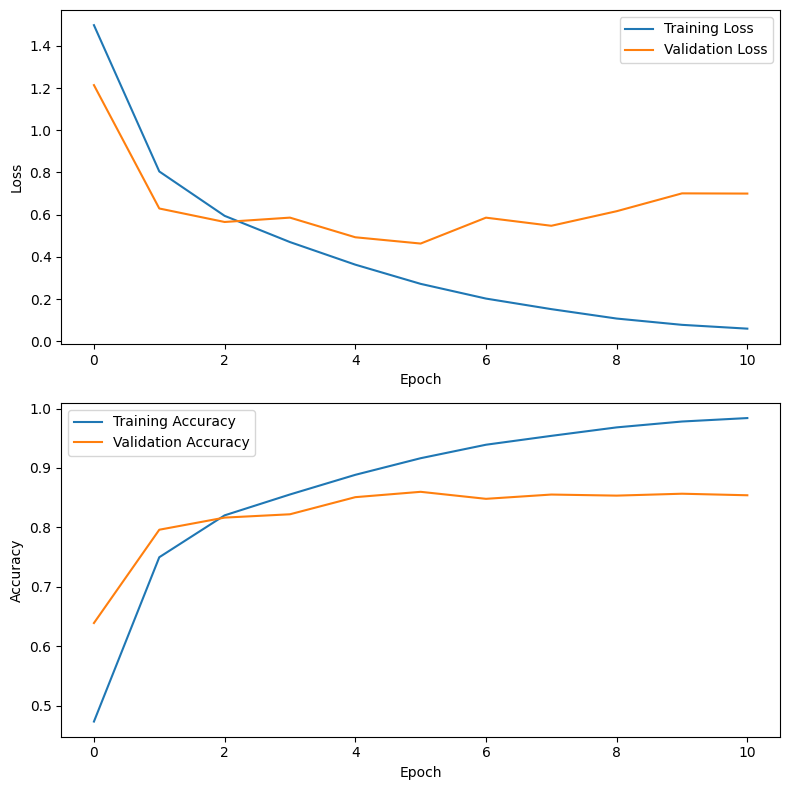

313/313 [==============================] - 4s 11ms/step - loss: 0.7435 - accuracy: 0.8569

Testing took 3.92 seconds

Average epoch time: 30.89 seconds



313/313 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

    airplane       0.86      0.91      0.88      1000
  automobile       0.90      0.94      0.92      1000
        bird       0.89      0.79      0.83      1000
         cat       0.67      0.77      0.72      1000
        deer       0.83      0.85      0.84      1000
         dog       0.78      0.78      0.78      1000
        frog       0.92      0.87      0.89      1000
       horse       0.88      0.88      0.88      1000
        ship       0.94      0.92      0.93      1000
       truck       0.94      0.87      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

313/313 [======================

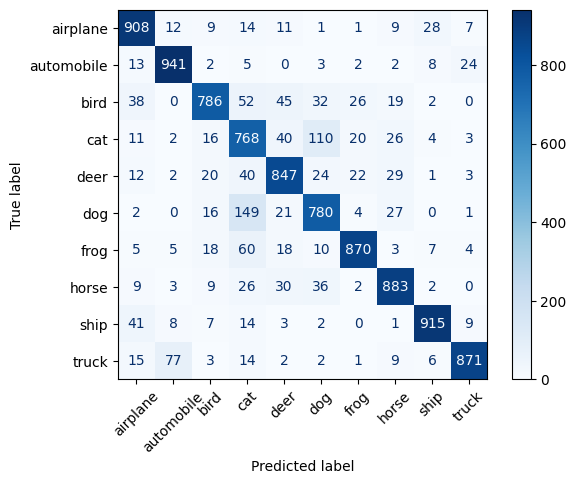

In [32]:
analyze_model(vgg_19, vgg19_history, vgg19_callbacks[-1], x_test, y_test_onehot)

In [33]:
def create_DenseNet201_model(input_shape: tuple, num_classes: int) -> tuple[keras.Model, keras.Model]:
    cnn_base = DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
    model = Sequential()
    model.add(cnn_base)
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return cnn_base, model

In [34]:
def create_DenseNet201_callbacks(model_name: str) -> list[keras.callbacks.Callback]:
    checkpoint = ModelCheckpoint(f"../models/{model_name}.h5", monitor="val_accuracy", save_best_only=True)
    early_stopping = EarlyStopping(monitor="val_accuracy", patience=5)
    epoch_time_callback = EpochTimeCallback()
    return [checkpoint, early_stopping, LR_sched, epoch_time_callback]

In [35]:
cnn_base_densenet201, densenet201 = create_DenseNet201_model(cifar10_input_shape, len(cifar10_labels))

In [36]:
layer_specific_summary(cnn_base_densenet201)

0 input_2 True
1 zero_padding2d True
2 conv1/conv True
3 conv1/bn True
4 conv1/relu True
5 zero_padding2d_1 True
6 pool1 True
7 conv2_block1_0_bn True
8 conv2_block1_0_relu True
9 conv2_block1_1_conv True
10 conv2_block1_1_bn True
11 conv2_block1_1_relu True
12 conv2_block1_2_conv True
13 conv2_block1_concat True
14 conv2_block2_0_bn True
15 conv2_block2_0_relu True
16 conv2_block2_1_conv True
17 conv2_block2_1_bn True
18 conv2_block2_1_relu True
19 conv2_block2_2_conv True
20 conv2_block2_concat True
21 conv2_block3_0_bn True
22 conv2_block3_0_relu True
23 conv2_block3_1_conv True
24 conv2_block3_1_bn True
25 conv2_block3_1_relu True
26 conv2_block3_2_conv True
27 conv2_block3_concat True
28 conv2_block4_0_bn True
29 conv2_block4_0_relu True
30 conv2_block4_1_conv True
31 conv2_block4_1_bn True
32 conv2_block4_1_relu True
33 conv2_block4_2_conv True
34 conv2_block4_concat True
35 conv2_block5_0_bn True
36 conv2_block5_0_relu True
37 conv2_block5_1_conv True
38 conv2_block5_1_bn True
3

In [37]:
cnn_base_densenet201.trainable = False
densenet201.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1, 1, 1920)        18321984  
                                                                 
 flatten_1 (Flatten)         (None, 1920)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               491776    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 10)               

In [38]:
froze_layers(cnn_base_densenet201, "conv5_block1_0_bn")
densenet201.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1, 1, 1920)        18321984  
                                                                 
 flatten_1 (Flatten)         (None, 1920)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               491776    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 10)               

In [39]:
densenet201_callbacks = create_DenseNet201_callbacks("densenet201")

In [40]:
densenet201_history = densenet201.fit(
    x_train,
    y_train_onehot,
    batch_size=64,
    epochs=50,
    validation_data=(x_val, y_val_onehot),
    callbacks=densenet201_callbacks,
)

Epoch 1/50
704/704 [==============================] - ETA: 0s - loss: 1.5289 - accuracy: 0.4716
Testing took 3.86 seconds


Epoch 1 took 78.66 seconds

704/704 [==============================] - 79s 94ms/step - loss: 1.5289 - accuracy: 0.4716 - val_loss: 0.7648 - val_accuracy: 0.7502 - lr: 9.0000e-05
Epoch 2/50
704/704 [==============================] - ETA: 0s - loss: 0.7678 - accuracy: 0.7596
Testing took 1.80 seconds


Epoch 2 took 64.53 seconds

704/704 [==============================] - 65s 92ms/step - loss: 0.7678 - accuracy: 0.7596 - val_loss: 0.5792 - val_accuracy: 0.8082 - lr: 8.1000e-05
Epoch 3/50
704/704 [==============================] - ETA: 0s - loss: 0.5351 - accuracy: 0.8345
Testing took 1.82 seconds


Epoch 3 took 66.21 seconds

704/704 [==============================] - 66s 94ms/step - loss: 0.5351 - accuracy: 0.8345 - val_loss: 0.5347 - val_accuracy: 0.8254 - lr: 7.2900e-05
Epoch 4/50
704/704 [==============================] - ETA: 0s - loss: 0.3862 - accuracy: 0.881




+---------------------+----------------------+
|       Metric        |        Value         |
+---------------------+----------------------+
|    Training Loss    | 0.015001139603555202 |
|   Validation Loss   |  0.7518032789230347  |
|  Training Accuracy  |  0.9960444569587708  |
| Validation Accuracy |  0.8611999750137329  |
+---------------------+----------------------+





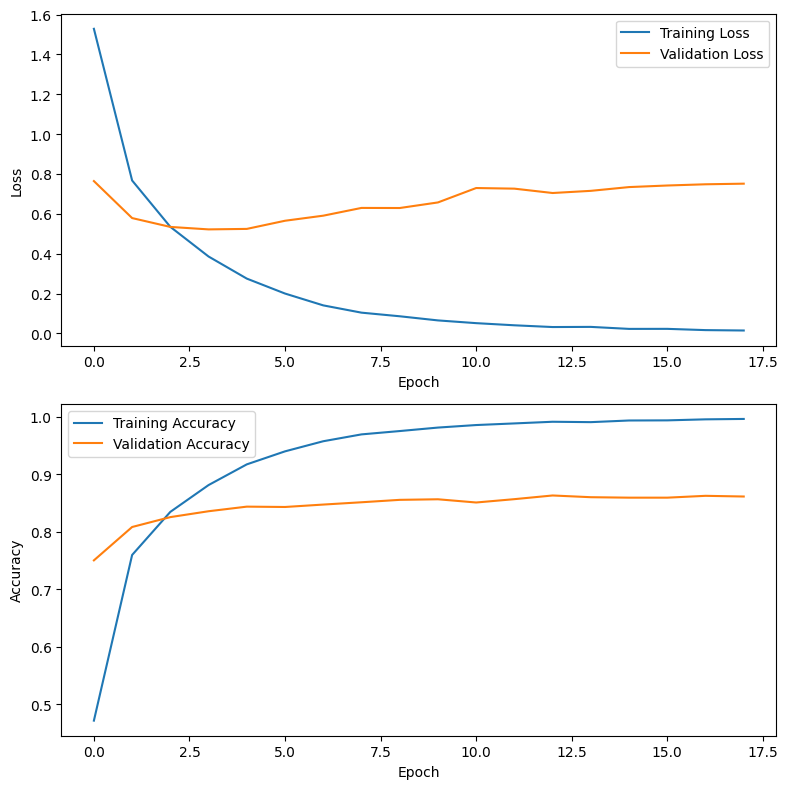

313/313 [==============================] - 7s 23ms/step - loss: 0.7981 - accuracy: 0.8576

Testing took 7.48 seconds

Average epoch time: 65.47 seconds



313/313 [==============================] - 9s 23ms/step
              precision    recall  f1-score   support

    airplane       0.89      0.88      0.89      1000
  automobile       0.92      0.93      0.93      1000
        bird       0.84      0.82      0.83      1000
         cat       0.71      0.73      0.72      1000
        deer       0.83      0.84      0.83      1000
         dog       0.81      0.75      0.78      1000
        frog       0.89      0.90      0.89      1000
       horse       0.87      0.89      0.88      1000
        ship       0.92      0.93      0.93      1000
       truck       0.91      0.91      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

313/313 [=====================

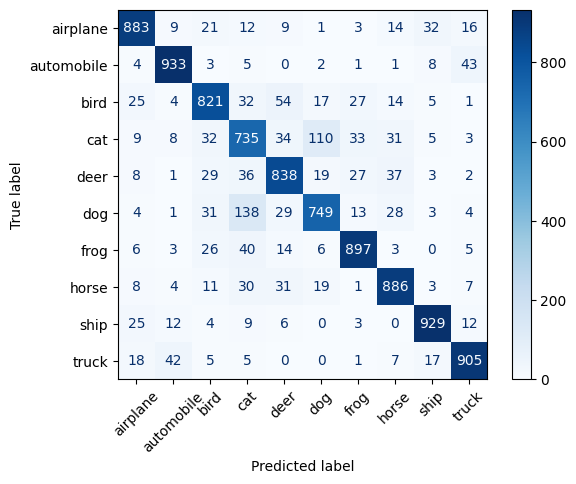

In [41]:
analyze_model(densenet201, densenet201_history, densenet201_callbacks[-1], x_test, y_test_onehot)

### Transformers
Now we do the same for the transformers

In [24]:
class CustomDataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray, transform=None):
        self.x = x
        self.y = y.squeeze() # PyTorch expects the labels to be 1D
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]

        if self.transform:
            x = self.transform(x)

        return x, y

In [25]:
transform = torchvision_transforms.Compose([
    torchvision_transforms.ToPILImage(),
    torchvision_transforms.Resize((224, 224)),
    torchvision_transforms.RandomHorizontalFlip(),
    torchvision_transforms.RandomRotation(15),
    torchvision_transforms.ToTensor(),
])

In [26]:
train_dataset = CustomDataset(x_train, y_train, transform=transform)
val_dataset = CustomDataset(x_val, y_val, transform=transform)
test_dataset = CustomDataset(x_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [27]:
def create_DeiTBaseDistilled_model(input_shape: tuple, num_classes: int, hidden_units: int) -> tuple[nn.Module, nn.Module]:
    base_model = timm.create_model("deit_base_distilled_patch16_224", pretrained=True, num_classes=0)
    
    model = nn.Sequential(
        nn.Linear(768, hidden_units),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(hidden_units, num_classes),
    )
    
    return base_model, model

In [28]:
deit_base_distilled_transformer, deit_base_distilled_fc = create_DeiTBaseDistilled_model(cifar10_input_shape, len(cifar10_labels), 256)

In [29]:
layers_names = [name for name, _ in deit_base_distilled_transformer.named_parameters()]
print(layers_names)

['cls_token', 'pos_embed', 'dist_token', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight', 'blocks.2.attn.proj.bias', 'blocks.2.norm2.weight', 'blocks.2.norm2.bias', 'blocks.2.mlp.fc1.weight', 'blocks.2.mlp.fc1.bias', 'blocks.2.mlp.fc2.weight', 'b

In [30]:
summary(deit_base_distilled_transformer)

Layer (type:depth-idx)                   Param #
VisionTransformerDistilled               153,600
├─PatchEmbed: 1-1                        --
│    └─Conv2d: 2-1                       590,592
│    └─Identity: 2-2                     --
├─Dropout: 1-2                           --
├─Identity: 1-3                          --
├─Identity: 1-4                          --
├─Sequential: 1-5                        --
│    └─Block: 2-3                        --
│    │    └─LayerNorm: 3-1               1,536
│    │    └─Attention: 3-2               2,362,368
│    │    └─Identity: 3-3                --
│    │    └─Identity: 3-4                --
│    │    └─LayerNorm: 3-5               1,536
│    │    └─Mlp: 3-6                     4,722,432
│    │    └─Identity: 3-7                --
│    │    └─Identity: 3-8                --
│    └─Block: 2-4                        --
│    │    └─LayerNorm: 3-9               1,536
│    │    └─Attention: 3-10              2,362,368
│    │    └─Identity: 3-11     

In [31]:
froze_layers_pytorch(deit_base_distilled_transformer, "blocks.11")

In [32]:
summary(deit_base_distilled_transformer)

Layer (type:depth-idx)                   Param #
VisionTransformerDistilled               153,600
├─PatchEmbed: 1-1                        --
│    └─Conv2d: 2-1                       (590,592)
│    └─Identity: 2-2                     --
├─Dropout: 1-2                           --
├─Identity: 1-3                          --
├─Identity: 1-4                          --
├─Sequential: 1-5                        --
│    └─Block: 2-3                        --
│    │    └─LayerNorm: 3-1               (1,536)
│    │    └─Attention: 3-2               (2,362,368)
│    │    └─Identity: 3-3                --
│    │    └─Identity: 3-4                --
│    │    └─LayerNorm: 3-5               (1,536)
│    │    └─Mlp: 3-6                     (4,722,432)
│    │    └─Identity: 3-7                --
│    │    └─Identity: 3-8                --
│    └─Block: 2-4                        --
│    │    └─LayerNorm: 3-9               (1,536)
│    │    └─Attention: 3-10              (2,362,368)
│    │    └─Ident

In [50]:
summary(deit_base_distilled_fc)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            196,864
├─ReLU: 1-2                              --
├─Dropout: 1-3                           --
├─Linear: 1-4                            65,792
├─ReLU: 1-5                              --
├─Dropout: 1-6                           --
├─Linear: 1-7                            2,570
Total params: 265,226
Trainable params: 265,226
Non-trainable params: 0

In [51]:
class DeiTBaseDistilledModel(nn.Module):
    def __init__(self, base_model: nn.Module, fc: nn.Module):
        super(DeiTBaseDistilledModel, self).__init__()
        self.base_model = base_model
        self.fc = fc
        
    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.fc(x)
        return x

In [52]:
deit_base_distilled_model = DeiTBaseDistilledModel(deit_base_distilled_transformer, deit_base_distilled_fc)
deit_base_distilled_model.to(device)

DeiTBaseDistilledModel(
  (base_model): VisionTransformerDistilled(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): 

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(deit_base_distilled_model.parameters(), lr=0.0001)

In [27]:
def train_model(
    model: nn.Module,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int,
) -> tuple[list, list, list, list]:
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    epoch_times = []

    for epoch in range(num_epochs):
        model.train()

        start = time.time()

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            y_pred = model(x)

            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item().__round__(2))
            train_acc.append((y_pred.argmax(dim=1) == y).float().mean().item().__round__(2))

        model.eval()

        with torch.no_grad():
            losses = []
            accuracies = []

            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                y_pred = model(x)

                loss = criterion(y_pred, y)
                losses.append(loss.item())
                accuracies.append((y_pred.argmax(dim=1) == y).float().mean().item())

            val_loss.append(np.mean(losses).__round__(2))
            val_acc.append(np.mean(accuracies).__round__(2))

        finish = time.time()
        epoch_times.append((finish - start).__round__(2))
        
        print(f"Epoch {epoch+1} took {finish - start:.2f} seconds, Train Loss: {train_loss[-1]}, Train Accuracy: {train_acc[-1]}, Validation Loss: {val_loss[-1]}, Validation Accuracy: {val_acc[-1]}")

    return train_loss, val_loss, train_acc, val_acc, epoch_times

In [ ]:
deit_base_distilled_train_loss, deit_base_distilled_val_loss, deit_base_distilled_train_acc, deit_base_distilled_val_acc, deit_base_distilled_epoch_times = train_model(deit_base_distilled_model, criterion, optimizer, train_loader, val_loader, 10)

Epoch 1 took 238.49 seconds, Train Loss: 1.09, Train Accuracy: 58.48, Validation Loss: 1.19, Validation Accuracy: 58.6
Epoch 2 took 239.37 seconds, Train Loss: 0.81, Train Accuracy: 71.74, Validation Loss: 0.87, Validation Accuracy: 70.25
Epoch 3 took 238.93 seconds, Train Loss: 0.73, Train Accuracy: 74.15, Validation Loss: 0.8, Validation Accuracy: 71.61
Epoch 4 took 239.78 seconds, Train Loss: 0.61, Train Accuracy: 78.87, Validation Loss: 0.65, Validation Accuracy: 77.19
Epoch 5 took 237.13 seconds, Train Loss: 0.49, Train Accuracy: 79.4, Validation Loss: 0.58, Validation Accuracy: 80.36
Epoch 6 took 239.06 seconds, Train Loss: 0.4, Train Accuracy: 84.03, Validation Loss: 0.49, Validation Accuracy: 81.14
Epoch 7 took 238.51 seconds, Train Loss: 0.47, Train Accuracy: 82.84, Validation Loss: 0.54, Validation Accuracy: 83.7
Epoch 8 took 239.44 seconds, Train Loss: 0.38, Train Accuracy: 86.3, Validation Loss: 0.42, Validation Accuracy: 85.79
Epoch 9 took 238.84 seconds, Train Loss: 0.38,




+---------------------+-------+
|       Metric        | Value |
+---------------------+-------+
|    Training Loss    | 0.41  |
|   Validation Loss   | 0.45  |
|  Training Accuracy  | 92.85 |
| Validation Accuracy | 90.55 |
+---------------------+-------+





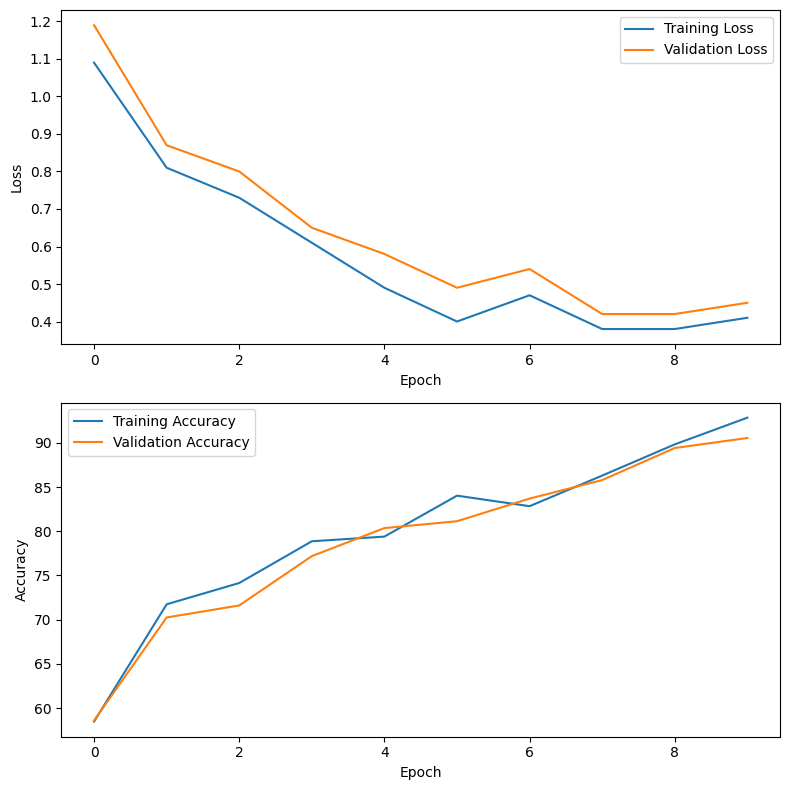

Average epoch time: 239.05 seconds
Loss: 0.37
Time taken: 4.02 seconds
              precision    recall  f1-score   support

    airplane       0.97      0.92      0.95      1000
  automobile       0.91      0.98      0.94      1000
        bird       0.99      0.76      0.86      1000
         cat       0.93      0.67      0.78      1000
        deer       0.88      0.97      0.92      1000
         dog       0.74      0.98      0.84      1000
        frog       0.94      0.99      0.96      1000
       horse       0.98      0.98      0.98      1000
        ship       0.92      0.99      0.95      1000
       truck       0.98      0.89      0.93      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



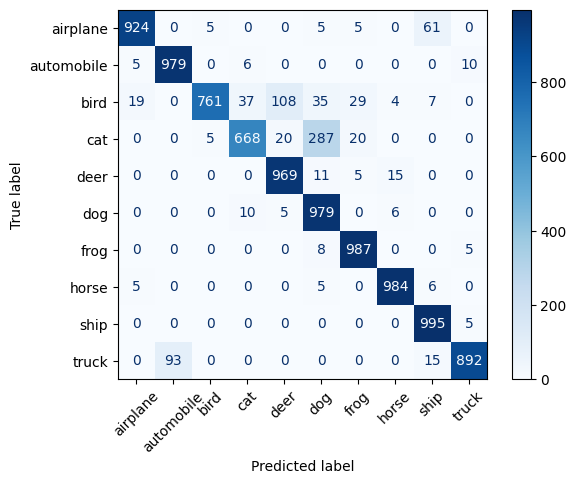

In [ ]:
analyze_model_pytorch(deit_base_distilled_model, criterion, optimizer, test_loader, y_test, deit_base_distilled_train_loss, deit_base_distilled_val_loss, deit_base_distilled_train_acc, deit_base_distilled_val_acc, deit_base_distilled_epoch_times)